# Link and bridges classification

## Stages

1. [Obtain input image](#Input)
2. [Pre processsing](#Ducument-preprocessing)
3. [Distance transform](#Distance-transform)
4. [Local maxima map](#Local-maxima)
5. [Graph building](#Graph)
 1. [Junction estimation](#Junction-pixels)
 2. [Vertices through centeroids](#Vertices)
 3. [Edges through BFS scan](#Edges)
6. [Dilute to 3 connected](#Dilute-to-3-connected)
7. [Edge classification](#Edge-classification)
 1. [T juncitons fuzzy set](#T-juncitons)
 2. [Center pixels fuzzy set](#Center-pixels)
 3. [Bridge direction estimation](#Bridge-direction-estimation)
 4. [Classification](#Classification)

In [1]:
from functools import reduce, partial
from itertools import repeat, product, combinations, chain
from operator import or_, add, itemgetter, attrgetter
from random import randint
from collections import deque, defaultdict
from enum import Enum

import cv2
import numpy as np
from numpy import (array,
                   flip,
                   zeros_like,
                   dot,
                   subtract,
                   multiply,
                   divide,
                   arange,
                   sign)
from numpy.linalg import norm

from matplotlib.pyplot import imshow, figure, subplots
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D# pylint: disable=unused-import

get_ipython().run_line_magic('matplotlib', 'inline')# pylint: disable=undefined-variable

## Morphing

In [2]:
def cross(shape):
    return cv2.getStructuringElement(cv2.MORPH_CROSS, shape)

def circle(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

def cvclose(image, kernel):
    return cv2.erode(cv2.dilate(image, kernel), kernel)

def constant_border(image, length, value):
    return cv2.copyMakeBorder(image,
                              length,
                              length,
                              length,
                              length,
                              cv2.BORDER_CONSTANT,
                              value=value)

# m-adjacent neighbors

 For a given image $I$ and a mask $M$, pixel $p, q$ are
 considered m-adjacent if one of the following is true

  1. $q$ is a 4-adjcent of $p$ where $p,q\in M$
  2. $q$ is diagonal of $q$ where $p, q\in M$ *and*
     there is no $\omega\in M$ where $\omega$
     is both 4-adjecent of $p$ and 4-adjecent of $q$


In [3]:
def is_in_image(pixel, shape):
    col, row = pixel
    rows, cols = shape
    return ((0 <= row < rows) and
            (0 <= col < cols))

def adjesent_m(pixel, mask):
    def is_in(pixel):
        col, row = pixel
        return is_in_image(pixel, mask.shape) and mask[row, col]

    def add_offset(offset):
        return tuple(map(add, pixel, offset))

    neighbors_4 = [offset
                   for offset in [(1, 0), (0, 1), (-1, 0), (0, -1)]
                   if is_in(add_offset(offset))]

    neighbors_diag = [(o_x, o_y)
                      for o_x, o_y in [(1, 1), (-1, 1), (-1, -1), (1, -1)]
                      if
                      set([(0, o_x), (o_y, 0)]).isdisjoint(neighbors_4) and
                      is_in(add_offset((o_x, o_y)))]

    return [add_offset(offset) for offset in neighbors_4 + neighbors_diag]

## Convertions

In [4]:
def uint8(image):
    return image.astype(np.uint8)

def arrayuint8(rows):
    return uint8(array(rows))

## Display

In [5]:
def as_display(image):
    if image.shape[-1] == 3:
        return image

    return cv2.cvtColor(cv2.normalize(image.astype(np.float),
                                      None,
                                      0,
                                      255,
                                      cv2.NORM_MINMAX).astype(np.uint8),
                        cv2.COLOR_GRAY2RGB)

def rand_color():
    return (randint(150, 200), randint(150, 200), randint(0, 255))

def show_lines(image, lines, colors, width=1):
    image_with_lines = as_display(image)
    for ((point1, point2), color) in zip(lines, colors):
        cv2.line(image_with_lines, point1, point2, color, width)

    return image_with_lines

def show_points(image, points, radius=2):
    image_with_circles = as_display(image)
    randcolor = (100, randint(150, 200), randint(0, 255))
    for point in points:
        cv2.circle(image_with_circles, point, radius, randcolor, thickness=-1)
    return image_with_circles

def figure_image(figsize=(20, 20), **kwargs):
    return figure(figsize=figsize, **kwargs)

def plot_lines_3d(lines, colors, **kwargs):
    _, axes = subplots(subplot_kw={'projection': '3d'}, **kwargs)
    axes.set_zlim3d(0, 2)
    for (xvals, yvals, zvals), color in zip(lines, colors):
        axes.plot(xvals, yvals, zvals, color=color)

def plot_surface(shape, zfunc):
    fig = figure(figsize=(15, 7))
    axes = fig.gca(projection='3d')

    xgrid, ygrid = np.meshgrid(*(arange(0, coord, 1) for coord in shape))
    zgrid = zfunc(xgrid, ygrid)
    axes.plot_surface(xgrid, ygrid, zgrid,
                      cmap="coolwarm",
                      linewidth=0,
                      antialiased=True)

    axes.set_zlim3d(0, 2)
    axes.zaxis.set_major_locator(LinearLocator(10))
    axes.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


# Input

We get a text document as input

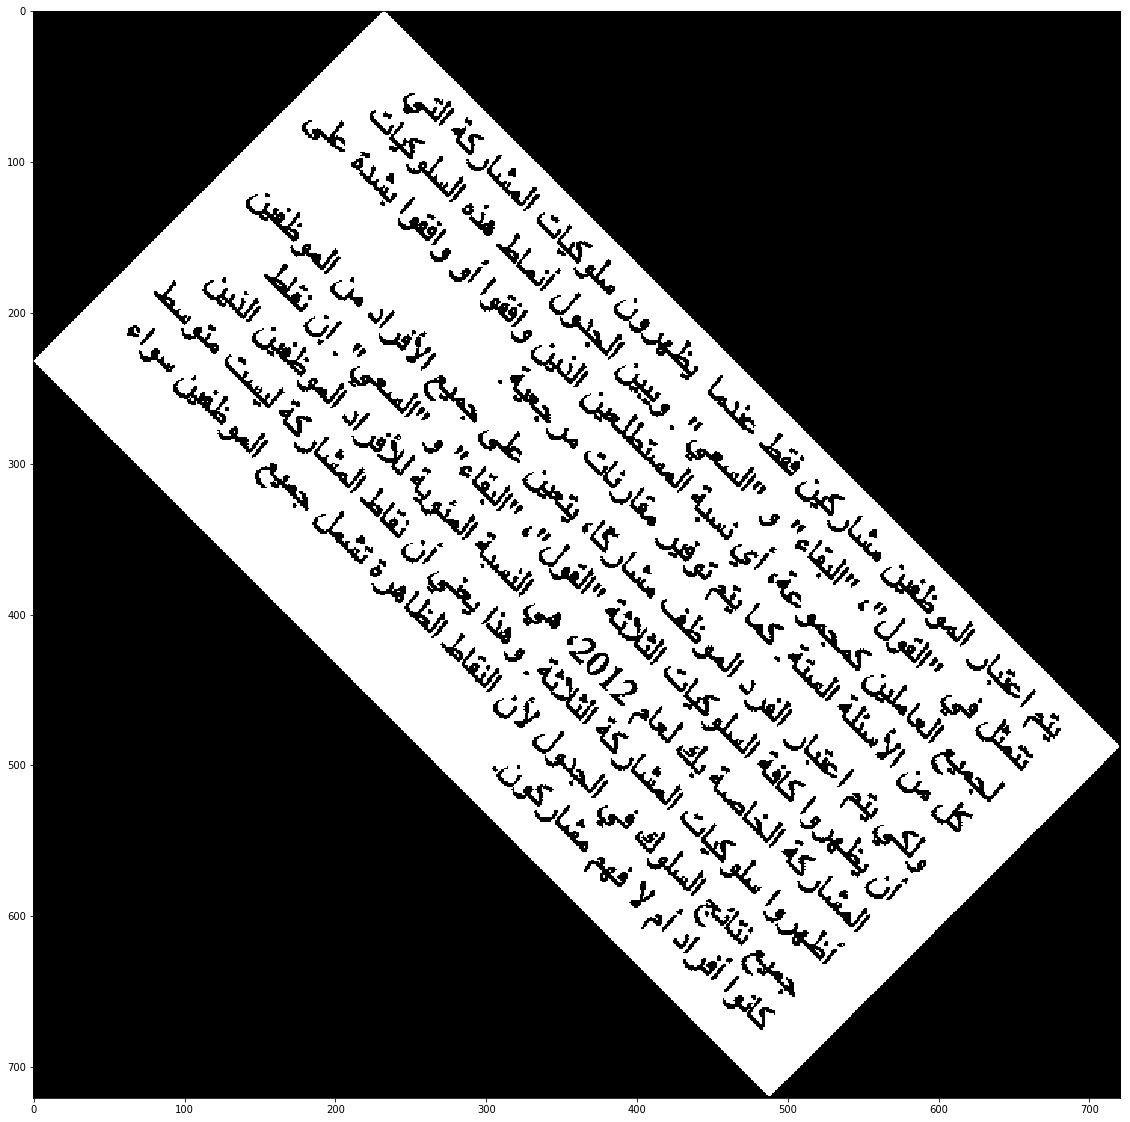

In [6]:
def read_document(path):
    return cv2.threshold(src=cv2.imread(path, cv2.IMREAD_GRAYSCALE),
                         thresh=200,
                         maxval=1,
                         type=cv2.THRESH_BINARY)[1]

TEXT = read_document("document_rot.jpg")

imshow(TEXT, cmap='gray', figure=figure_image())

# Ducument preprocessing
We erode input to emphasize words and add a black border to force graph edges at picture sides

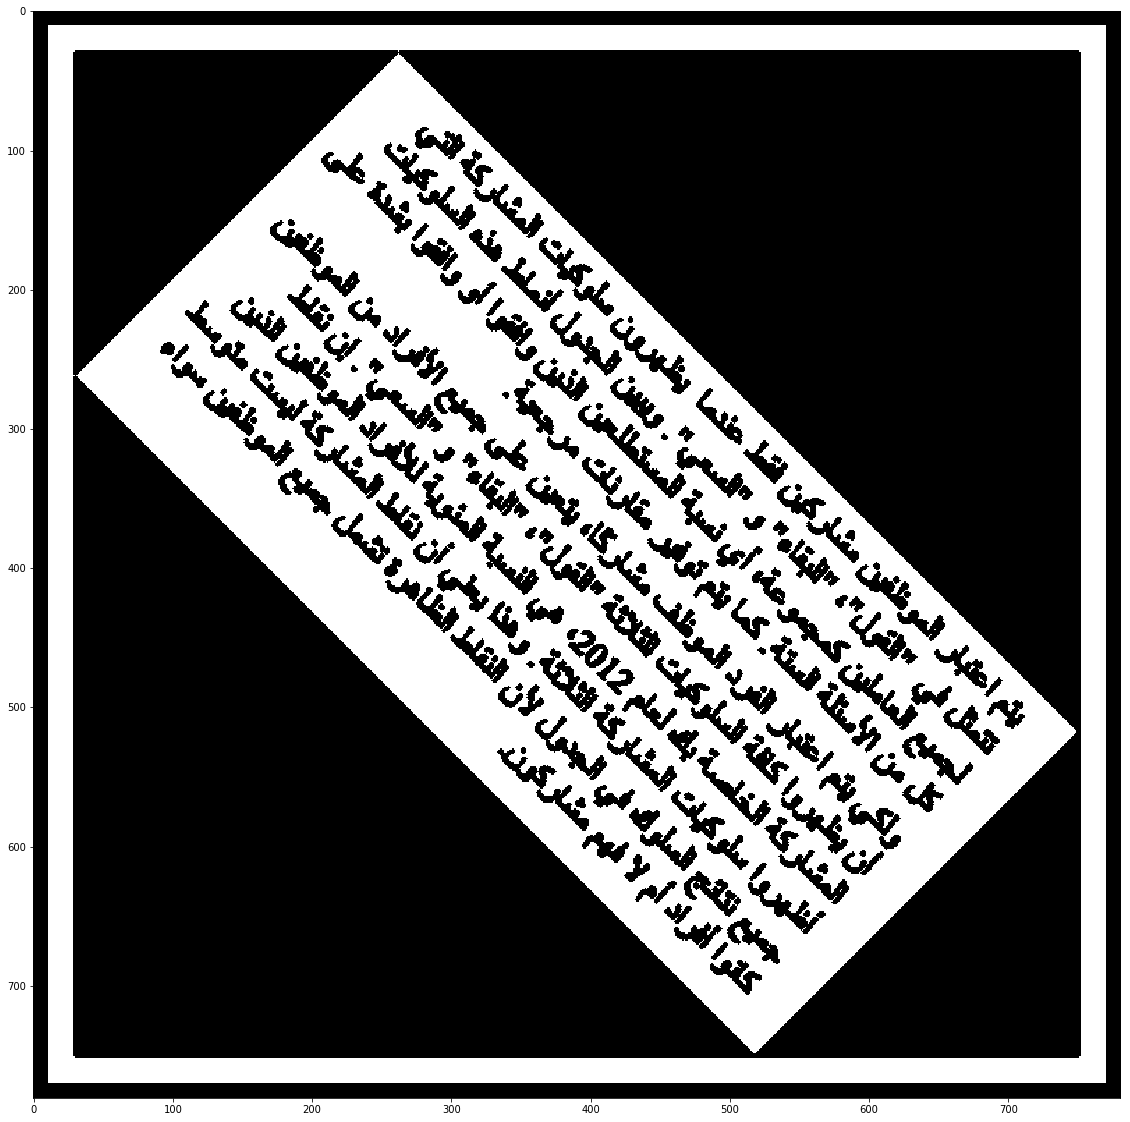

In [7]:
def preprocess(image):
    white_border = 20
    black_border = 10
    return (constant_border(image, 30, 1),
            cv2.erode(constant_border(constant_border(image, white_border, 1),
                                      black_border, 0),
                      circle(3)))

TEXT_SHOW, TEXT_ERODE = preprocess(TEXT)
imshow(TEXT_ERODE, cmap='gray', figure=figure_image())

# Distance transform

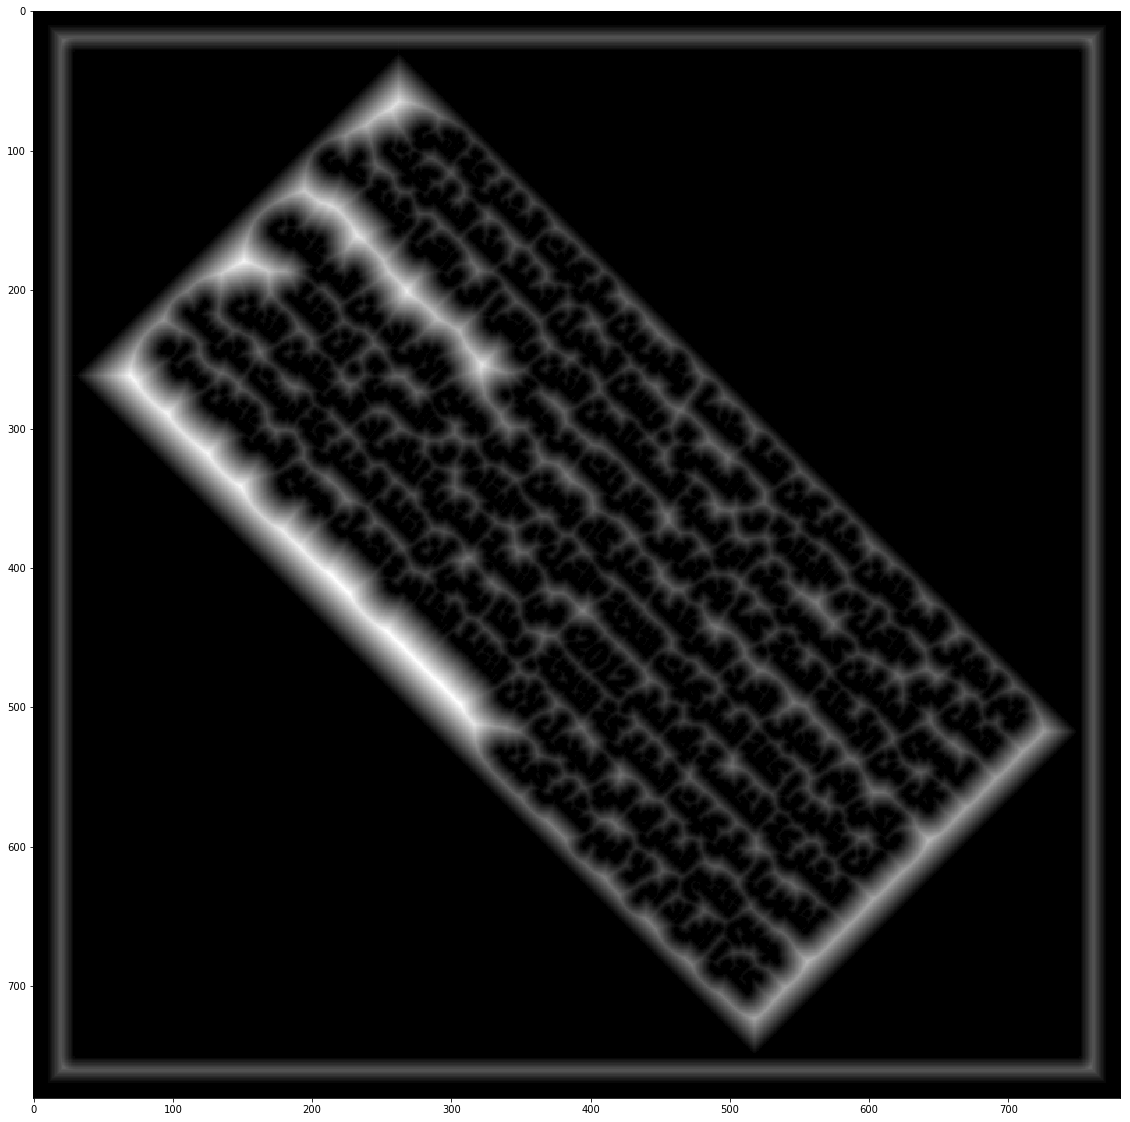

In [8]:
DIST = cv2.distanceTransform(TEXT_ERODE, cv2.DIST_L2, cv2.DIST_MASK_5)
imshow(DIST, cmap='gray', figure=figure_image())

# Local maxima

Each pixel $p$ is consider local maximum if $p > q_1 \wedge p> q_2$ where $q_1, q_2$ are opposite pixels in the 8-member inviroment of $p$

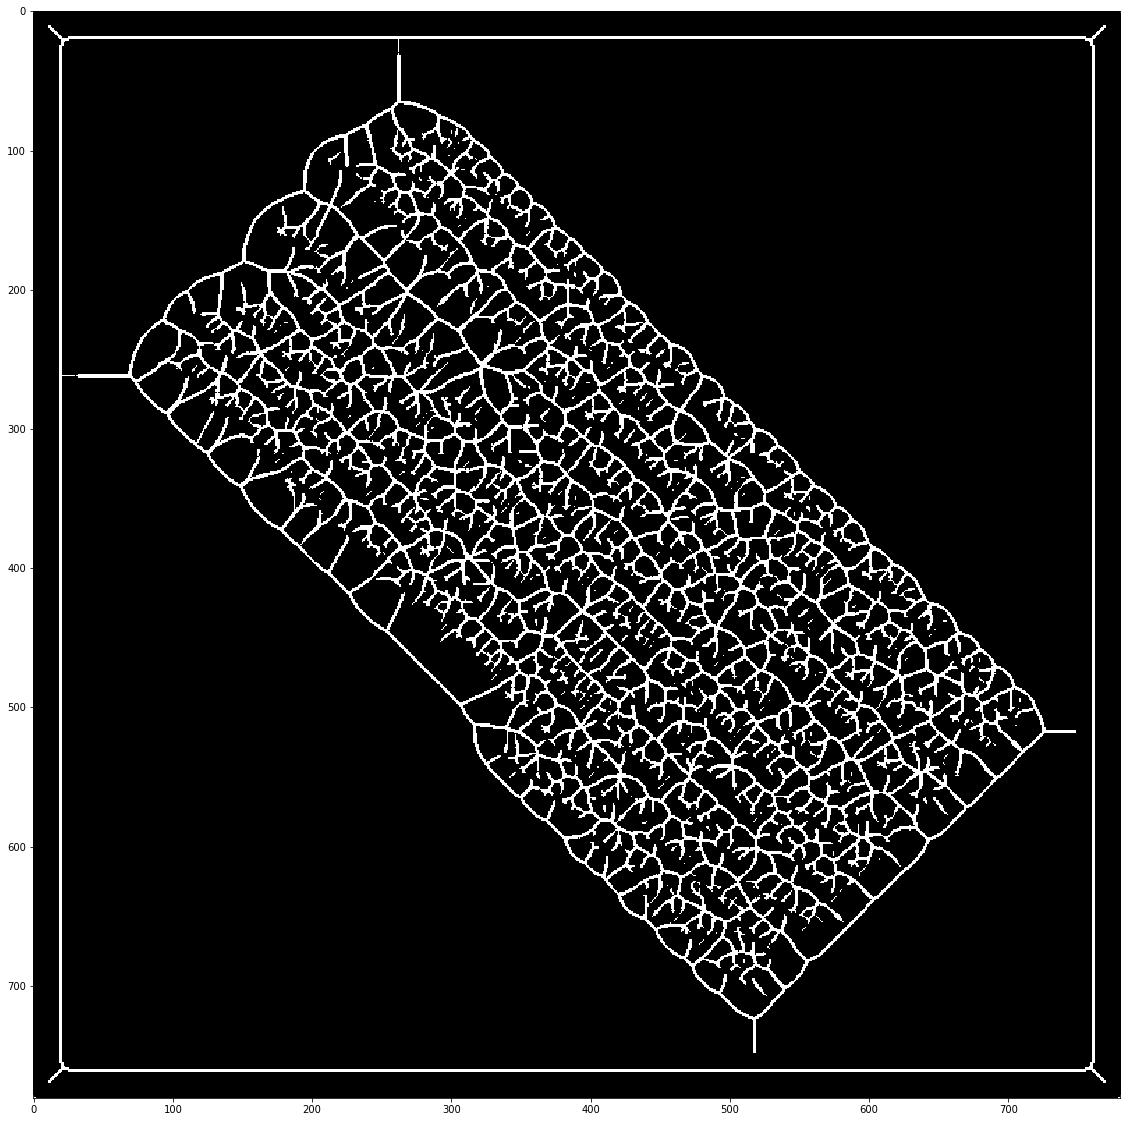

In [9]:
def local_maxima(image):

    horizontals = list(map(arrayuint8, [
        [
            [0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0]
        ],
        [
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0]
        ],
    ]))

    horizontals_fliped = [flip(mat, 1) for mat in horizontals]


    kernels = [mat
               for matrices in [(mat, mat.T) for mat in horizontals + horizontals_fliped]
               for mat in matrices]

    local_maximas = (image > cv2.dilate(image, kernel)
                     for kernel in kernels)

    return uint8(reduce(or_, local_maximas))

LOCAL_DIST_MAXIMA = local_maxima(DIST)

imshow(LOCAL_DIST_MAXIMA, cmap='gray', figure=figure_image())

# Graph

We extract the vertices and the edges from the local maxima matrix

## Junction pixels

Using erode, we find juntions checking various predefined shapes.

e.g

Given the following shape,


$\begin{pmatrix}0&0&0&0&0\\0&0&0&0&0\\1&1&\textbf{p}&1&1\\0&0&1&0&0\\0&0&1&0&0 \end{pmatrix}$

If the shape exists in distmap local maxima (meaning all if the shape pixels are $1$), the pixel $p$ is a junciton pixel.

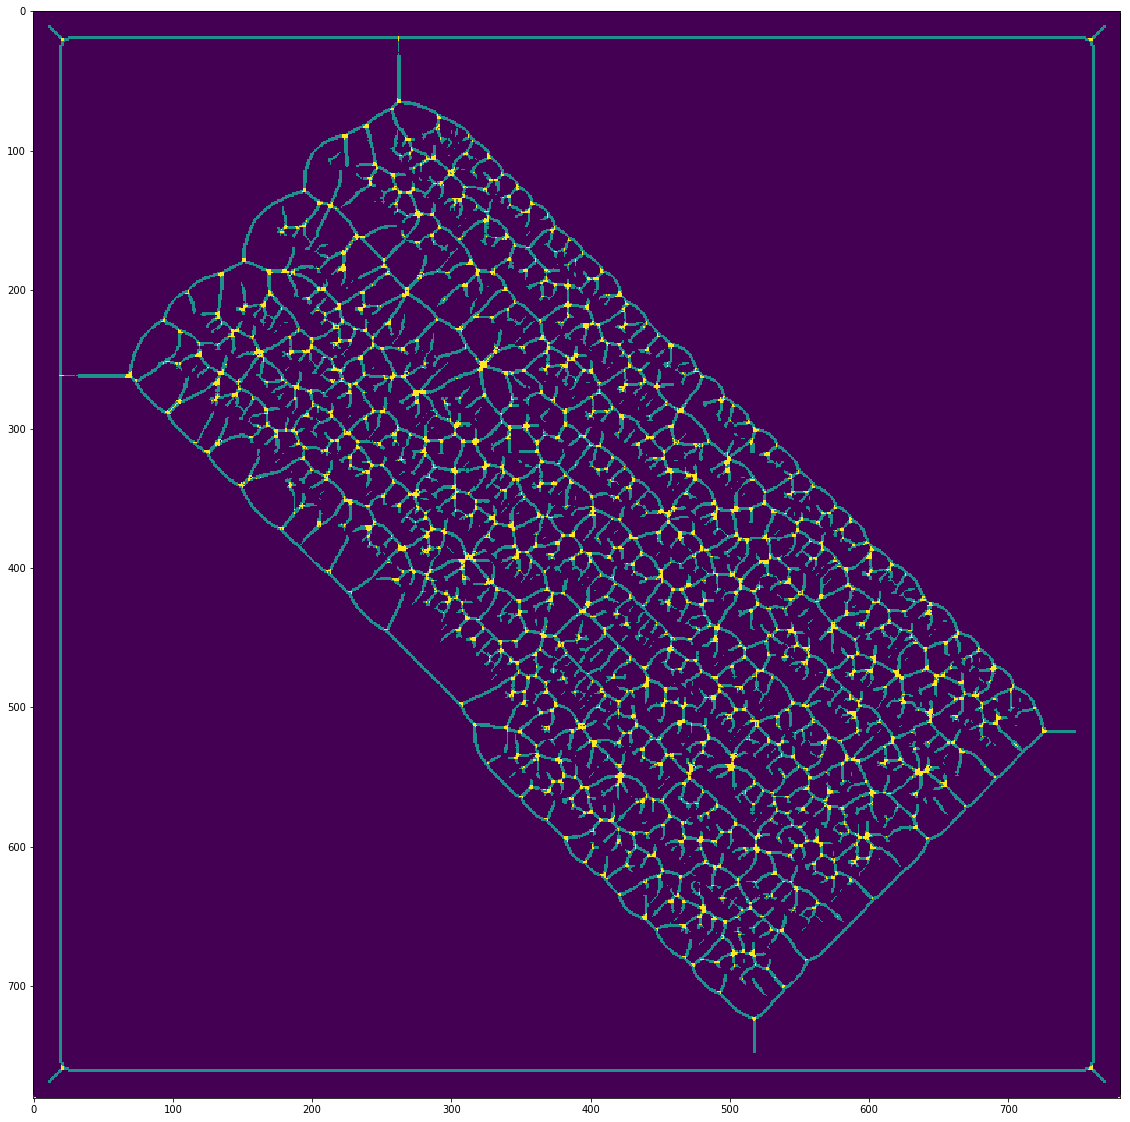

In [10]:
def rotations(mat):
    return (mat, mat.T, flip(mat, 0), flip(mat.T, 1))

def mark_junction_pixels(binary):
    junctions = map(arrayuint8, [
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 1, 0],
            [1, 1, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 1],
            [0, 1, 0, 1, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [1, 1, 1, 1, 1],
            [1, 0, 1, 0, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ]
    ])

    rotated_mats = (rotated
                    for mat in junctions
                    for rotated in rotations(mat))

    return reduce(or_,
                  map(partial(cv2.erode, binary), rotated_mats), zeros_like(binary))

imshow(LOCAL_DIST_MAXIMA + mark_junction_pixels(LOCAL_DIST_MAXIMA),
       figure=figure_image())

## Vertices
We define vertices as centeroids of each connected component of juntion pixels

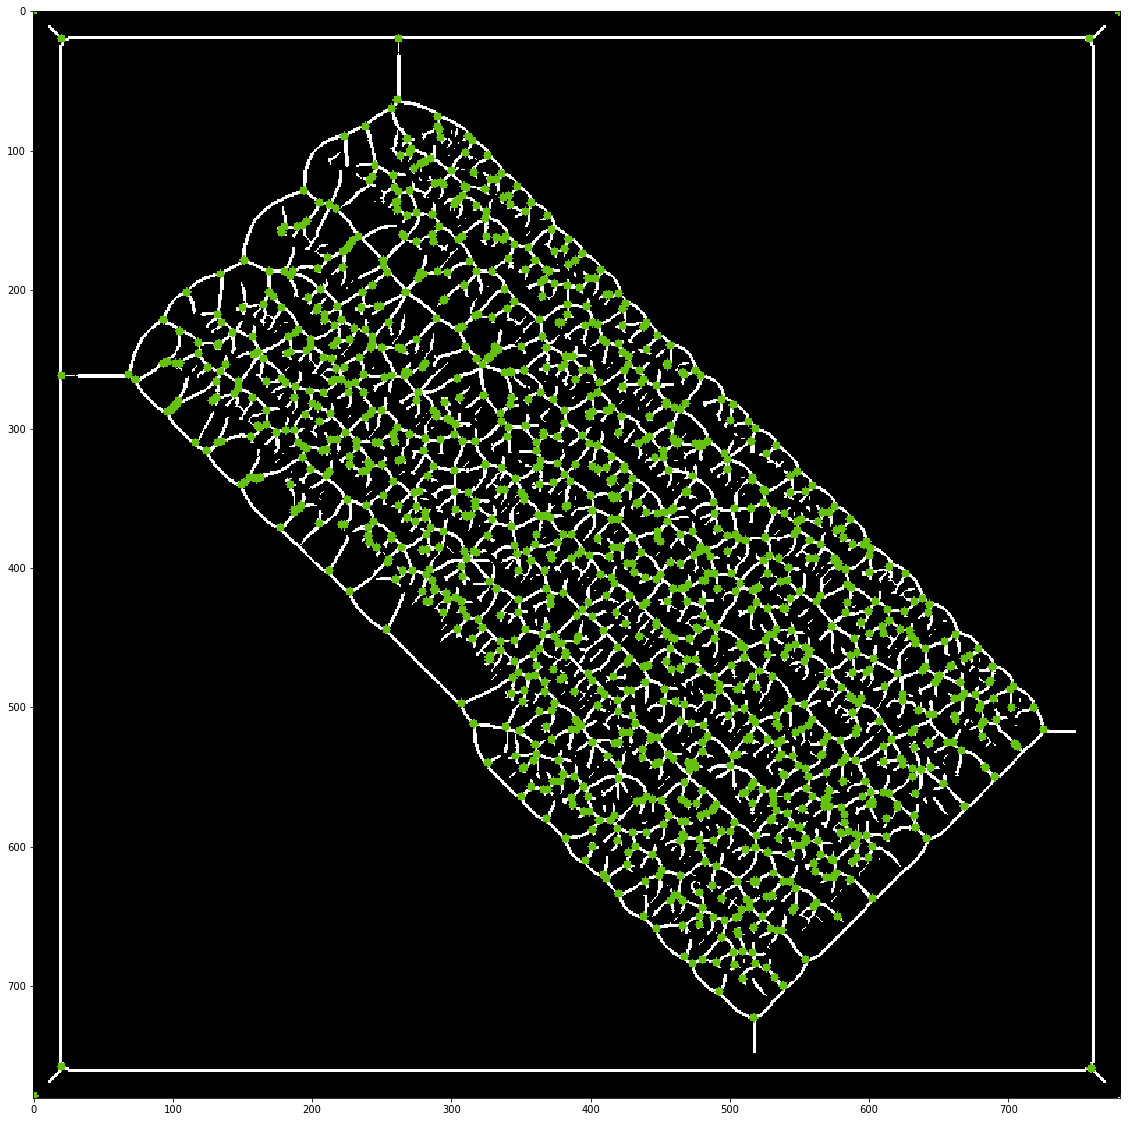

In [11]:
def extract_vertices(junction_pixels):
    _, labels, _, centeroids = cv2.connectedComponentsWithStats(
        junction_pixels,
        connectivity=4
    )
    return ([tuple(map(int, point)) for point in centeroids[1:-1]],
            labels - 1)


LOCAL_MAX_VERTS, LABELS = extract_vertices(mark_junction_pixels(LOCAL_DIST_MAXIMA))
imshow(show_points(LOCAL_DIST_MAXIMA, LOCAL_MAX_VERTS, 3),
       figure=figure_image())

 # Edges

## BFS
* We define set $V=$ [vertices](#vertices)
* While $V\neq \emptyset$
  - Start from some $v \in V$ and set $V = V - \{v\}$
  - Perform a $BFS$ scan on [local maxima](#Local-maxima) starting from $v$ iterating m-adjecent neighbors
  - Add all found neighbors of $v$ into the graph as vonnected to $v$

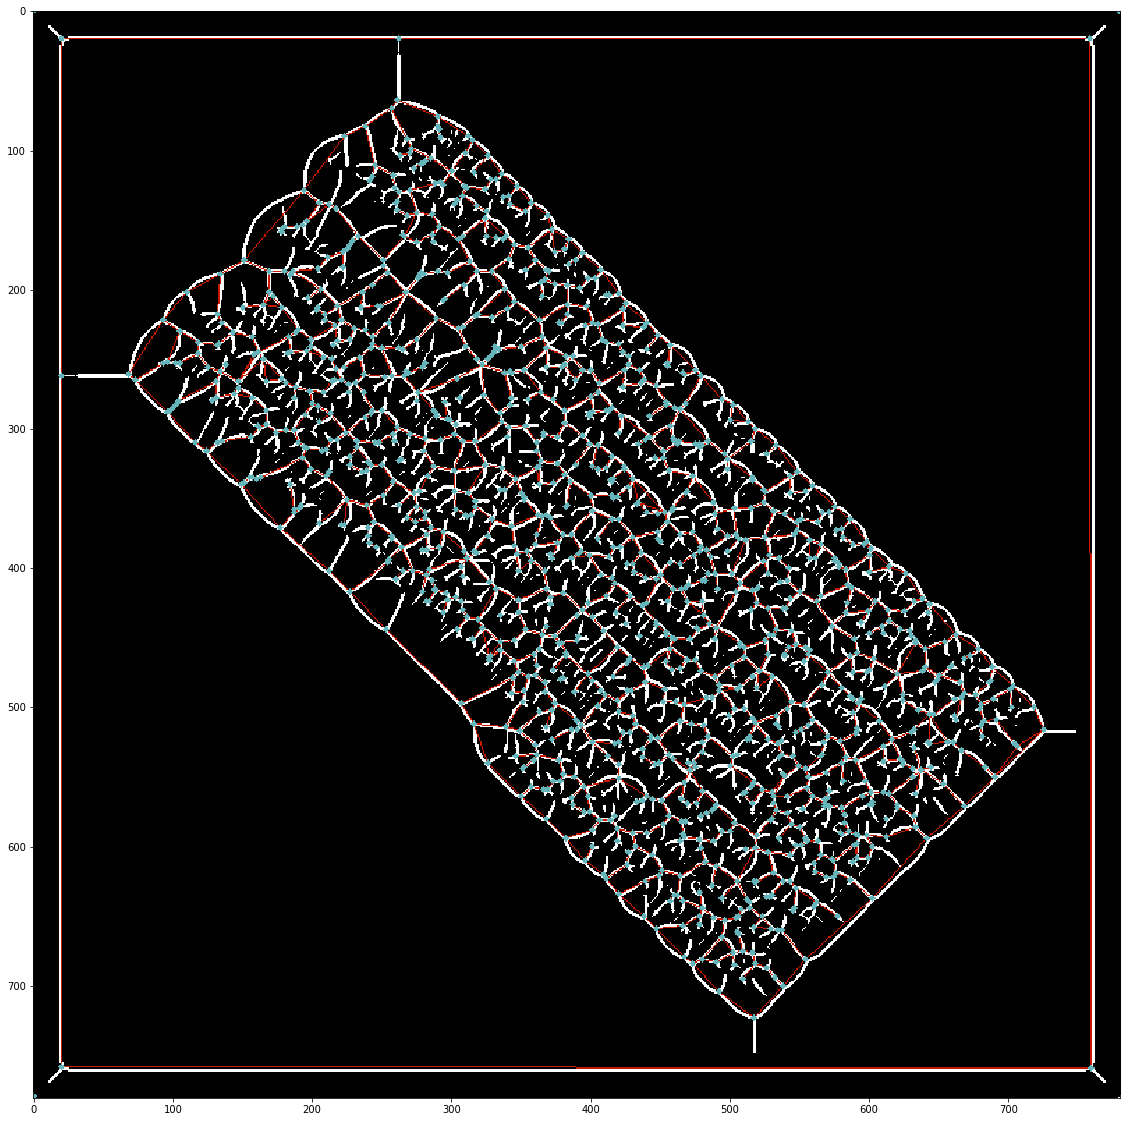

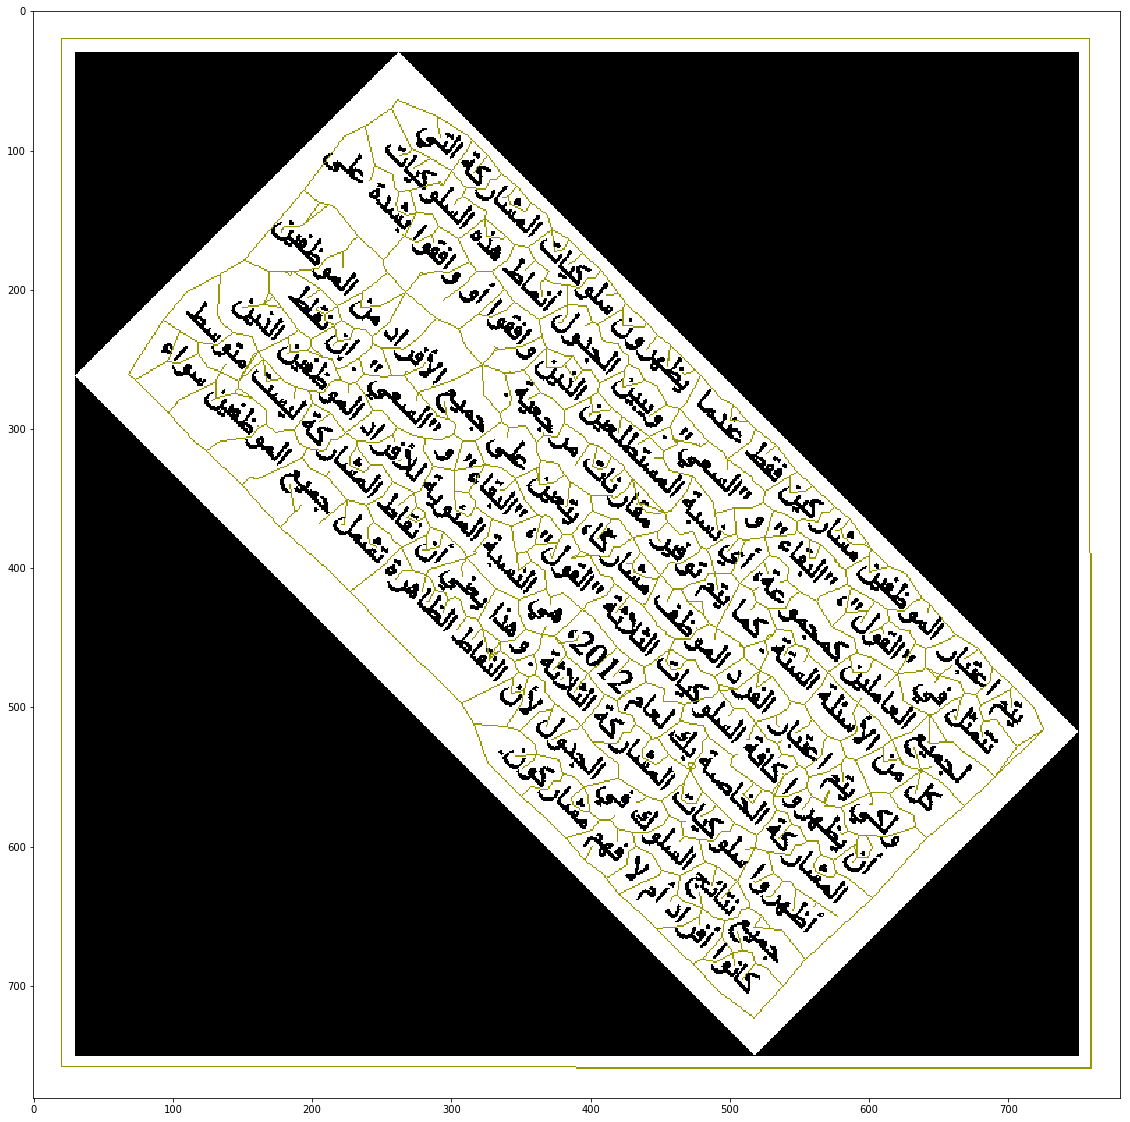

In [12]:
def area_to_vert(verts, radius):
    return dict((point, (x, y))
                for (x, y) in verts
                for point in product(range(x - radius, x + radius),
                                     range(y - radius, y + radius)))

def pixel_vert(pos, verts, labels_map, area_map):
    col, row = pos
    label = labels_map[row, col]
    if 0 <= label < len(verts):
        return verts[label]
    else:
        return area_map.get(pos)

def mask_connected(start, search_mask, covermap):
    visited = set()
    bfs_q = deque([start])

    while bfs_q:
        pos = bfs_q.popleft()
        vert = covermap(pos) or start
        if start == vert:
            next_verts = [v for v in adjesent_m(pos, search_mask) if v not in visited]
            visited.update(next_verts)
            bfs_q.extend(next_verts)
        else:
            yield vert

def build_graph(verts, find_connected_verts):
    edges = ((vert1, vert2)
             for vert1 in verts
             for vert2 in find_connected_verts(vert1))

    graph = defaultdict(set)

    for vert1, vert2 in edges:
        graph[vert1].add(vert2)
        graph[vert2].add(vert1)

    return graph

def remove_verts(graph, rmverts):
    for vert in rmverts:
        graph.pop(vert)

    graph.update((vert, neighbors - rmverts)
                 for vert, neighbors in graph.items())

def graph_edges(graph):
    return set(tuple(sorted((vert1, vert2)))
               for vert1, connecetd in graph.items()
               for vert2 in connecetd)

GRAPH = build_graph(
    verts=set(LOCAL_MAX_VERTS),
    find_connected_verts=partial(mask_connected,
                                 search_mask=LOCAL_DIST_MAXIMA,
                                 covermap=partial(
                                     pixel_vert,
                                     labels_map=LABELS,
                                     verts=LOCAL_MAX_VERTS,
                                     area_map=area_to_vert(LOCAL_MAX_VERTS, 3)
                                 )))

imshow(
    show_points(
        show_lines(
            LOCAL_DIST_MAXIMA,
            graph_edges(GRAPH),
            repeat((200, 24, 0)),
            width=1),
        LOCAL_MAX_VERTS, 2),
    figure=figure_image())

imshow(show_lines(TEXT_SHOW, graph_edges(GRAPH), repeat((150, 150, 0))),
       figure=figure_image())

# Dilute to 3-connected

Until we get a graph where all it's vertices have at least 3 neighbors, we rebuild the graph by find all 3 connected neighbors for vertice with at least 3 neighbors.

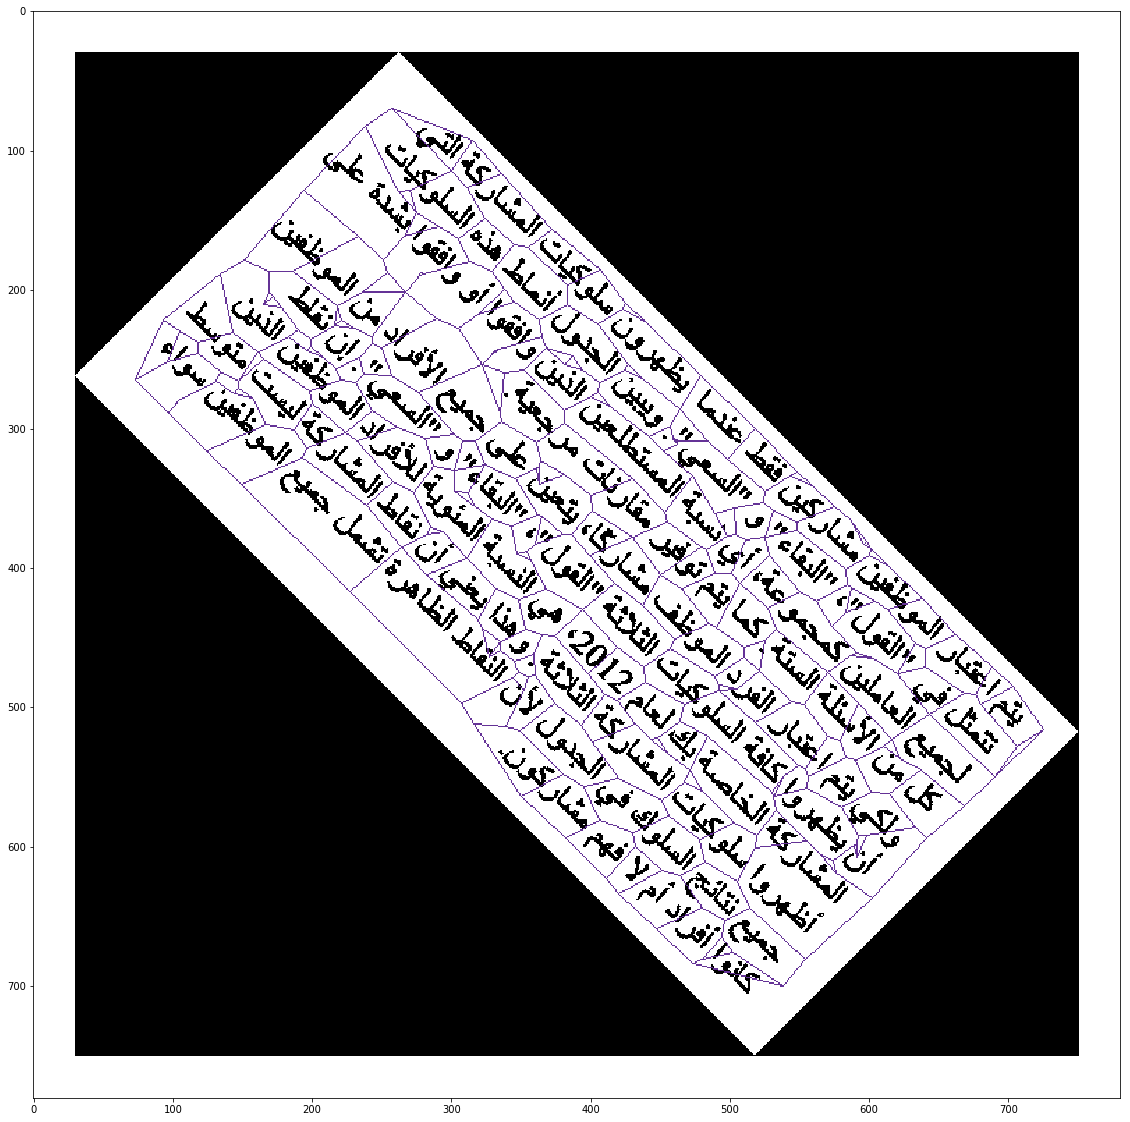

In [13]:
def graph_connected(start, graph):
    visited = set()
    bfs_q = deque([start])

    while bfs_q:
        connected_verts = [
            (vert, len(graph[vert])) for vert in graph[bfs_q.popleft()]
            if vert not in visited and vert != start]
        
        next_verts = [vert
                      for vert, nconnected in connected_verts
                      if nconnected <= 2]

        visited.update(next_verts)
        bfs_q.extend(next_verts)

        for vert in [vert
                     for vert, nconnected in connected_verts
                     if nconnected > 2]:
            yield vert

def dilute_to_3_connected(graph):
    graph3 = graph.copy()
    while True:
        verts3 = [vert for vert, verts in graph3.items() if len(verts) > 2]

        if len(verts3) == len(graph3.keys()):
            return graph3

        graph3 = build_graph(
            verts=verts3,
            find_connected_verts=partial(graph_connected, graph=graph3))

GRAPH_3 = dilute_to_3_connected(GRAPH)

imshow(show_lines(TEXT_SHOW, graph_edges(GRAPH_3), repeat((100, 50, 150))),
       figure=figure_image())

# Edge classification

## T juncitons
We use fuzzy logic to determin if a vertex is of a T juntion.

For any vertex $v_0$ with 3 neighbors $v_1, v_2, v_3$ Let
$VS=\{\vec{v_0v_1}, \vec{v_0v_2}, \vec{v_0v_3}\}$ And let $\theta_1, \theta_2, \theta_3$ be angles between each two vector pair $\vec{\tilde{v_1}}, \vec{\tilde{v_2}} \in VS$

We check how much each angle is close to $90^{\circ}$ by calculating
$\frac{\tilde{v_1}\cdot\tilde{v_2}}{\Vert\tilde{v_1} \rVert\Vert\tilde{v_2} \rVert} = \cos(\theta)$ and seeing how close to zero it is.

The juntion grade is the second closest angle to $90^{\circ}$ out of $\theta_1\dots \theta_3$ (for a perfect T juntion, we expect angles $90^{\circ}, 90^{\circ}, 180^{\circ}$)

In [14]:
def vcos(vec1, vec2):
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def t_grade(vert, connected_verts):
    if len(connected_verts) != 3:
        return (0, None)

    vectors = (subtract(vert2, vert) for vert2 in connected_verts)
    cosines = (((vec1, vec2), abs(vcos(vec1, vec2)))
               for vec1, vec2 in combinations(vectors, 2))
    sorted_grades = sorted(cosines, key=itemgetter(1))

    sorted_pairs = [tuple(map(tuple, vec_pair))
                    for vec_pair, _ in sorted_grades]

    linear_grade = 1 - sorted_grades[1][1]
    graded_vec = set(sorted_pairs[0]).intersection(sorted_pairs[1]).pop()

    return (linear_grade ** 2, divide(graded_vec, norm(graded_vec)))

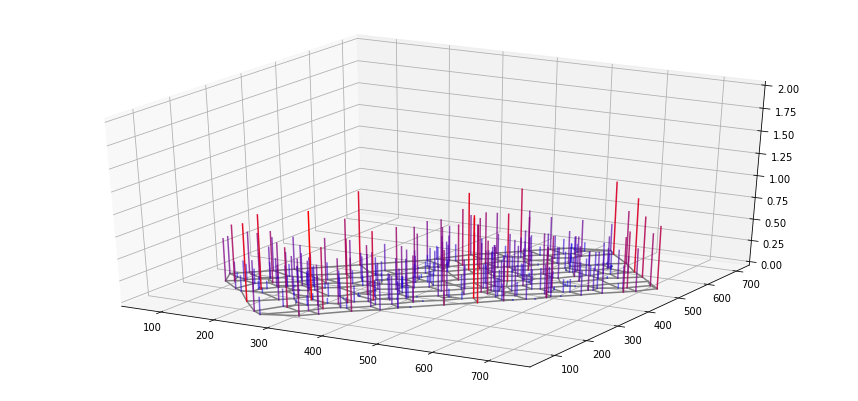

In [15]:
def plot_t_juncitons(edges, t_grades):
    t_grades = list(t_grades)
    graph_lines_3d = [tuple(zip(*edge)) + ((0, 0),) for edge in edges]
    tgrades_lines_3d = [
        (
            (x, x),
            (y, y),
            (0, grade)
        )
        for (x, y), grade in t_grades]

    plot_lines_3d(
        chain(graph_lines_3d,
              tgrades_lines_3d),
        chain(repeat("gray", len(graph_lines_3d)),
              ((grade, 0, 1 - grade, 0.5 + grade / 2)
               for _, grade in t_grades)),
        figsize=(15, 7))

plot_t_juncitons(graph_edges(GRAPH_3),
                 ((vert, t_grade(vert, connected_verts)[0]) for vert, connected_verts in GRAPH_3.items()))

## Center pixels
we want to eliminate pixels at the edges of the pictures therefore we use a fuzzy set $Center$

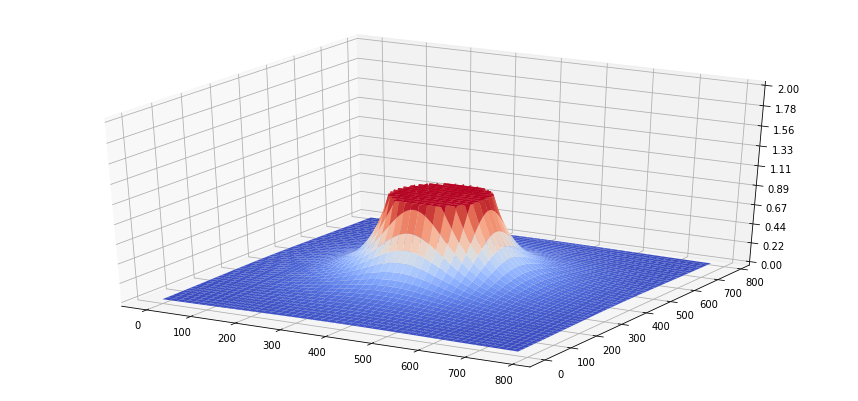

In [16]:
def center_fuzzy_set(p_x, p_y, shape):
    max_x, max_y = shape
    delta = 0.005

    radius = ((p_x - max_x / 2)**2 + (p_y - max_y/2)**2)** 0.5
    return reduce(np.minimum,
                  [1,
                   1 / (0.5 + radius * delta)** 4])

plot_surface(TEXT_SHOW.shape[::-1], partial(center_fuzzy_set, shape=TEXT_SHOW.shape[::-1]))

We are looking for $v$ where $v\in \textrm{T-juntion}\wedge v \in \textrm{Center-pixels}$ (performed in fuzzy sets logic)

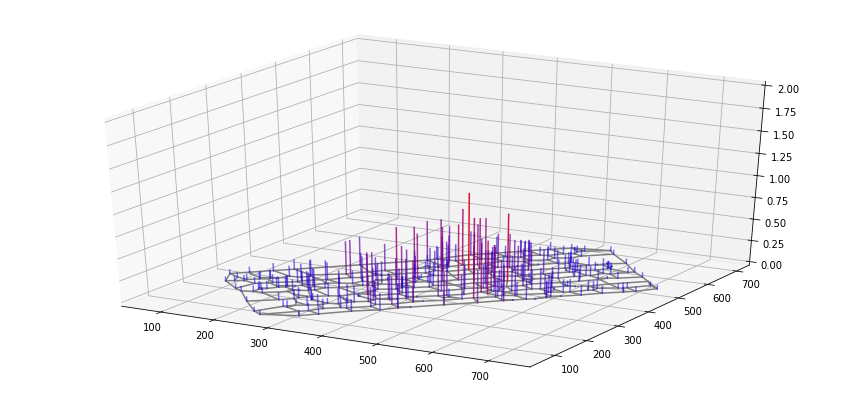

In [17]:
def centered_t_grades(graph, shape):
    t_grades = [(v, t_grade(v, vs)) for v, vs in graph.items()]
    return [
        (
            (x, y),
            min(grade, center_fuzzy_set(x, y, shape)),
            grade_vec
        )
        for (x, y), (grade, grade_vec) in t_grades]

plot_t_juncitons(graph_edges(GRAPH_3),
                 map(itemgetter(0, 1), centered_t_grades(GRAPH_3, TEXT_SHOW.shape[::-1])))

# Bridge direction estimation 

Let t-juntion grade be $g_t$ and center pixel gade be $g_c$

The direction vector of bridges is defined as a weighted avarage of each total grade ,$\min{(g_t,g_c)}$, times its corrospondeing middle vector's direction.

In [18]:
centered_t_grades(GRAPH_3, TEXT_SHOW.shape[::-1])

[((592, 497), 0.1383832524634854, array([-0.43381562,  0.90100167])),
 ((616, 523), 0, None),
 ((579, 524), 0.13331586985520388, array([-0.9486833 , -0.31622777])),
 ((570, 475), 0, None),
 ((583, 536), 0.1179142482889175, array([-0.31622777, -0.9486833 ])),
 ((570, 521), 0.14897166273409, array([-0.57106449,  0.8209052 ])),
 ((610, 528), 0.09631430862854126, array([0.8, 0.6])),
 ((622, 537), 0.017789569010282953, array([-0.3939193 , -0.91914503])),
 ((643, 505), 0, None),
 ((586, 463), 0.014708004807729793, array([0.9931506 , 0.11684125])),
 ((533, 444), 0.367333816634768, array([-0.70710678,  0.70710678])),
 ((553, 498), 0.21172701348107031, array([ 0.59439106, -0.80417614])),
 ((590, 538), 0.10896193934320314, array([0.4314555 , 0.90213422])),
 ((637, 545), 0.0685146254803666, array([-0.80417614,  0.59439106])),
 ((690, 550), 0, None),
 ((668, 490), 0.04534518327204755, array([-0.85749293,  0.51449576])),
 ((620, 476), 0, None),
 ((591, 461), 0.055986049951426135, array([-0.92847669

In [19]:
def bridge_grade(edge, t_grades):
    edge_dir = subtract(*edge)
    return (
        sum(abs(vcos(edge_dir, vec)) * grade for grade, vec in t_grades)
        /
        sum(grade for grade, _ in t_grades)
    )

# Classification
Using abs of cos value between the estimated bridge direction vector, we determine how close each edge is to be a bridge. that way we clssify each edge to be either a bridge or a link

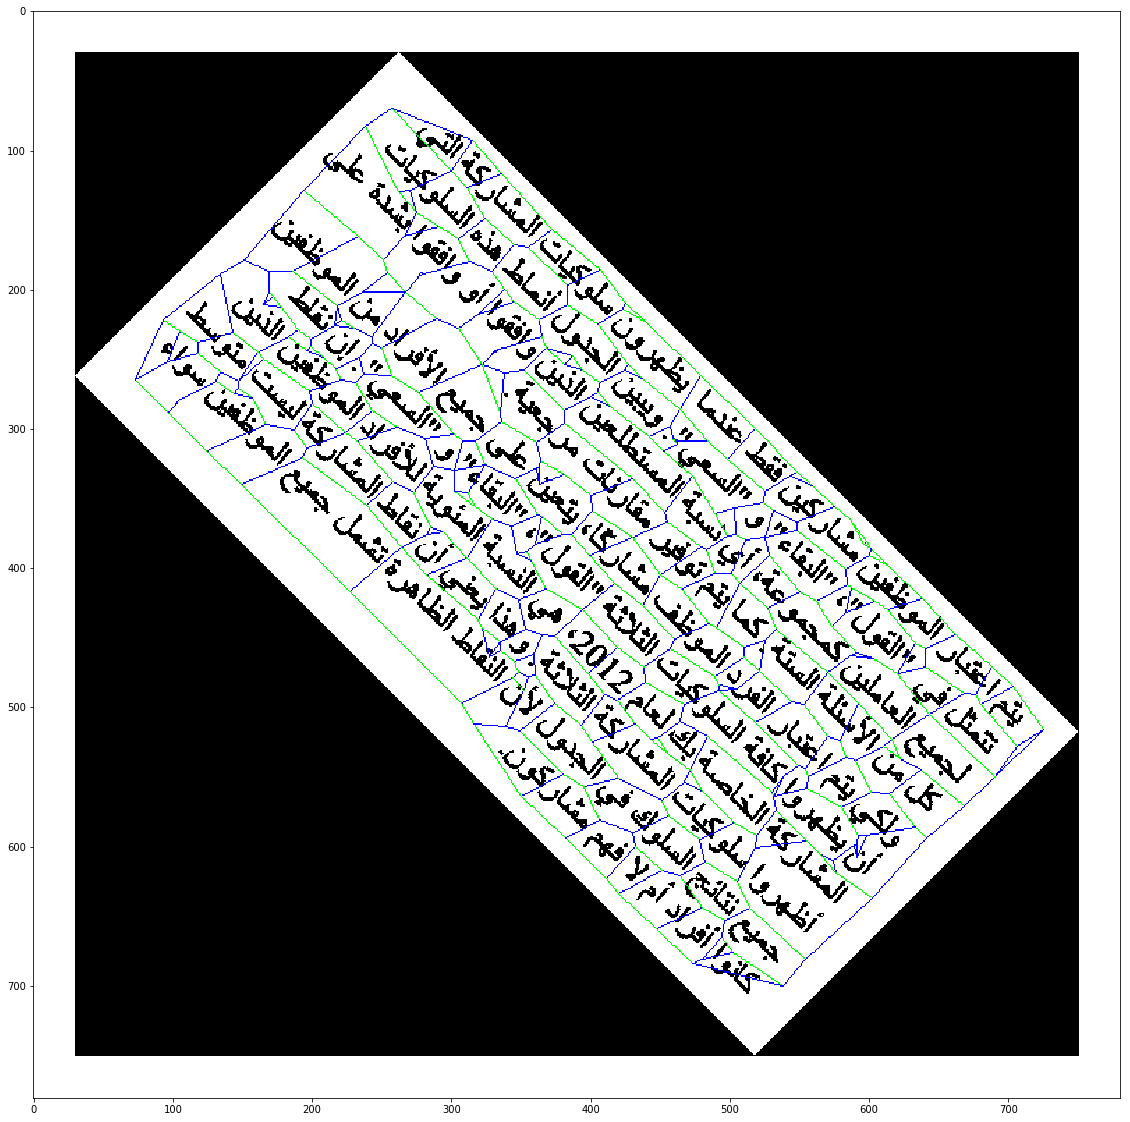

In [20]:
class EdgeType(Enum):
    BRIDGE = (0, 0, 255) # blue
    LINK = (0, 255, 0) # green

def classify_edges(graph, t_grades):
    cleaned_t_grades = [(grade, vec) for _, grade, vec in t_grades if vec is not None]
    return [
        (
            edge,
            EdgeType.BRIDGE if bridge_grade(edge, cleaned_t_grades) > 0.5 else EdgeType.LINK
        )
        for edge in graph_edges(graph)
    ]

CLASSIFIED = classify_edges(GRAPH_3,
                            centered_t_grades(GRAPH_3, TEXT_SHOW.shape[::-1]))

imshow(show_lines(TEXT_SHOW,
                  map(itemgetter(0), CLASSIFIED),
                  map(attrgetter('value'), map(itemgetter(1), CLASSIFIED))),
       figure=figure_image())

In [21]:
def run_all(path):
    text_show, text_erode = preprocess(read_document(path))
    dist_maxima = local_maxima(cv2.distanceTransform(text_erode, cv2.DIST_L2, cv2.DIST_MASK_5))

    max_verts, labels = extract_vertices(mark_junction_pixels(dist_maxima))

    graph = build_graph(
        verts=set(max_verts),
        find_connected_verts=partial(mask_connected,
                                     search_mask=dist_maxima,
                                     covermap=partial(
                                         pixel_vert,
                                         labels_map=labels,
                                         verts=max_verts,
                                         area_map=area_to_vert(max_verts, 3)
                                     )))

    graph_3 = dilute_to_3_connected(graph)

    classified = classify_edges(graph_3,
                                centered_t_grades(
                                    graph_3,
                                    text_show.shape[::-1]
                                )
                               )

    imshow(show_lines(text_show,
                      map(itemgetter(0), classified),
                      map(attrgetter('value'), map(itemgetter(1), classified))),
           figure=figure_image())

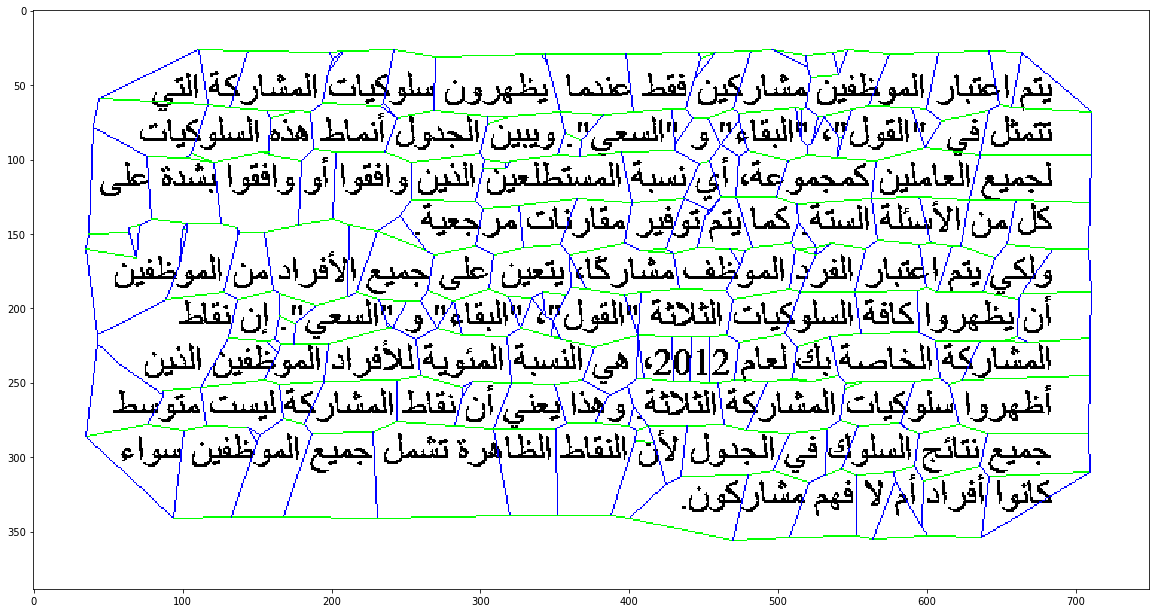

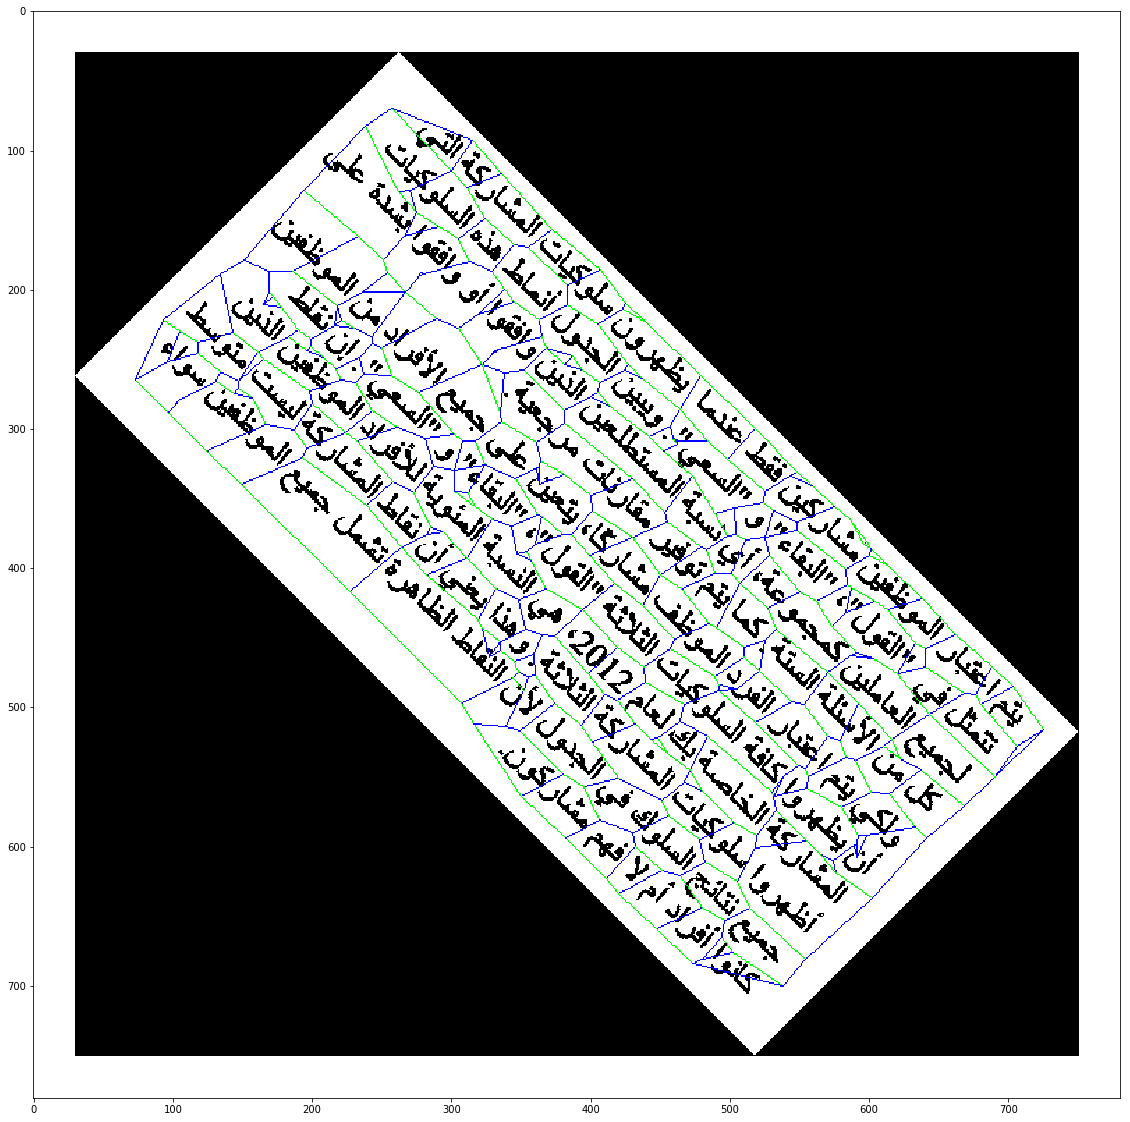

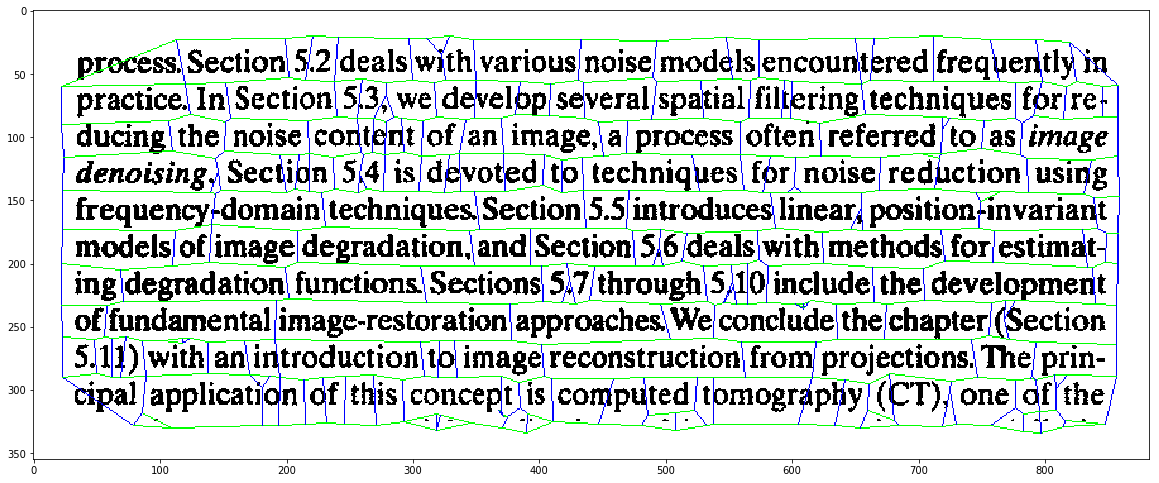

In [22]:
run_all("document.jpg")
run_all("document_rot.jpg")
run_all("document2.jpg")